# Testing Best Batch size on Fashion MNIST Dataset
The goal if this experiment is to determine how altering the batch size of training data affects convergence time, and affects the overall efficiency and accuracy of the model.
We will be using the fashion mnist dataset.

## Getting The Data

In [73]:
import tensorflow_datasets as tfds

(train_data, test_data), ds_info = tfds.load(name="fashion_mnist",
                                             split=["train", "test"],
                                             as_supervised=True,
                                             with_info=True,
                                             shuffle_files=True)

## Confirming Data

In [74]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from datetime import datetime

In [75]:
train_sample = train_data.take(1)
class_names = ds_info.features["label"].names

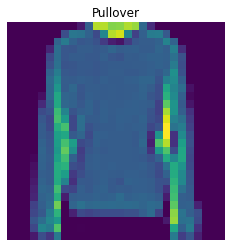

In [76]:
for image, label in train_sample:
  plt.imshow(image)
  plt.title(class_names[label])
  plt.axis(False)

In [77]:
for image, label in train_sample:
  print(image.shape)

(28, 28, 1)


## Setting up preprocessing and checkpoints

In [78]:
def preprocess_img(image, label):
  image = tf.cast(image, tf.float32)
  image = image/255.
  return (tf.cast(image, tf.float32), label)

In [79]:
checkpoint_base = tf.keras.callbacks.ModelCheckpoint("models/checkpoints/model_open.h5",
                                                      save_best_only=True,
                                                      monitor="val_loss",
                                                      verbose=0)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3)

## Training and collecting data

In [80]:
tf.random.set_seed(42)
results = {}

for batch_size in range(4, 257, 4):
  print(f"Working on batch_size: {batch_size}")
  train_data_preprocessed = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
  train_data_ready = train_data_preprocessed.shuffle(buffer_size=1024).batch(batch_size=batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
  test_data_ready = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

  start_time = datetime.now()

  input_shape = (28, 28, 1)
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(10,3, activation="relu", input_shape=input_shape),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2,padding="valid"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(class_names), activation="softmax")                                                   
  ])


  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

  history = model.fit(train_data_ready,
                      epochs=50,
                      steps_per_epoch=len(train_data_ready),
                      validation_data=test_data_ready,
                      validation_steps=len(test_data_ready),
                      callbacks=[early_stopping, checkpoint_base])

  loaded_model = tf.keras.models.load_model("models/checkpoints/model_open.h5")

  time_taken = (datetime.now() - start_time).total_seconds()
  loss, accuracy = loaded_model.evaluate(test_data_ready)
  results[batch_size] = {'loss': loss,
                         'accuracy': accuracy,
                         'no_of_epochs': len(history.epoch),
                         'total_seconds': time_taken}


Working on batch_size: 4
Epoch 1/50
15000/15000 [==============================] - 79s 5ms/step - loss: 0.4030 - accuracy: 0.8581 - val_loss: 0.3578 - val_accuracy: 0.8730
Epoch 2/50
15000/15000 [==============================] - 79s 5ms/step - loss: 0.2968 - accuracy: 0.8944 - val_loss: 0.3141 - val_accuracy: 0.8888
Epoch 3/50
15000/15000 [==============================] - 79s 5ms/step - loss: 0.2638 - accuracy: 0.9050 - val_loss: 0.2939 - val_accuracy: 0.8959
Epoch 4/50
15000/15000 [==============================] - 79s 5ms/step - loss: 0.2448 - accuracy: 0.9112 - val_loss: 0.2969 - val_accuracy: 0.8991
Epoch 5/50
15000/15000 [==============================] - 78s 5ms/step - loss: 0.2325 - accuracy: 0.9162 - val_loss: 0.2871 - val_accuracy: 0.9021
Epoch 6/50
15000/15000 [==============================] - 78s 5ms/step - loss: 0.2234 - accuracy: 0.9197 - val_loss: 0.2991 - val_accuracy: 0.8984
Epoch 7/50
15000/15000 [==============================] - 79s 5ms/step - loss: 0.2149 - accur

## Graphing Results

In [84]:
import pandas as pd


In [86]:
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df.head()

,loss,accuracy,no_of_epochs,total_seconds
4,0.287092,0.9021,8,628.854582
8,0.267642,0.9079,9,373.115697
12,0.267642,0.9079,8,223.698244
16,0.267642,0.9079,10,229.522647
20,0.265269,0.9066,9,164.249708


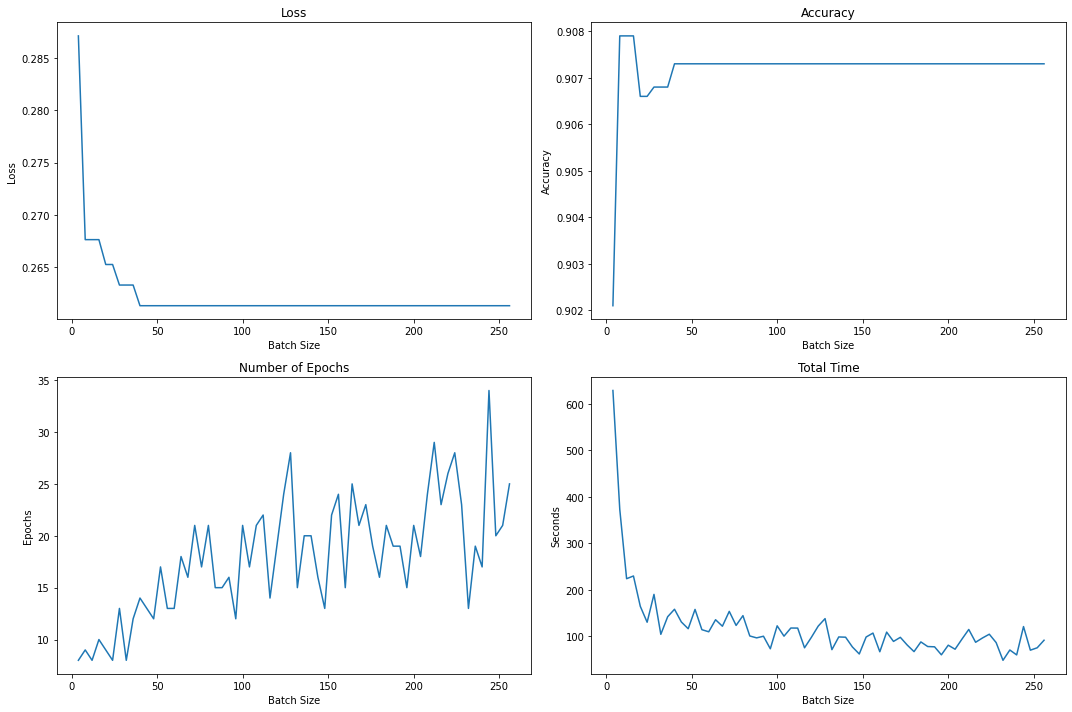

In [121]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

x = results_df.index

fig.set_figheight(10)
fig.set_figwidth(15)

ax1.plot(x, results_df['loss'])
ax1.set_title("Loss")
ax1.set_xlabel("Batch Size")
ax1.set_ylabel("Loss")
ax2.plot(x, results_df['accuracy'])
ax2.set_title("Accuracy")
ax2.set_xlabel("Batch Size")
ax2.set_ylabel("Accuracy")
ax3.plot(x, results_df['no_of_epochs'])
ax3.set_title("Number of Epochs")
ax3.set_xlabel("Batch Size")
ax3.set_ylabel("Epochs")
ax4.plot(x, results_df['total_seconds'])
ax4.set_title("Total Time")
ax4.set_xlabel("Batch Size")
ax4.set_ylabel("Seconds")

fig.tight_layout()